Restaurant analysis of restaurants,bars and diners in Brooklyn,New York

Downloading required dictionaries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

print('Libraries imported.')

Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Converting the json data into a dataframe

In [5]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Selecting neighborhoods in Brooklyn

In [6]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Finding geographical coordinates of Brooklyn using Geopy

In [7]:
address = 'Brooklyn, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.6501038, -73.9495823.


In [8]:
brooklyn_map = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(brooklyn_map)  
    
brooklyn_map

Entering Foursquare API details

In [9]:
CLIENT_ID = 'ZRUZ4NWNQYPEUM21RRCTYFD15HCS4FSXHX55EOIYBEC5LD24' 
CLIENT_SECRET = 'LRHVJCUOWW15CAWDSXP1BMIK050KDM0MEJF4VSYDE131NR0L' 
VERSION = '20180605' 
LIMIT = 100
radius = 500


Function to send multiple requests to obtain venue data

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
brooklyn_venues = pd.DataFrame()
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [12]:
brooklyn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [13]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,47,47,47,47,47,47
Bay Ridge,89,89,89,89,89,89
Bedford Stuyvesant,27,27,27,27,27,27
Bensonhurst,37,37,37,37,37,37
Bergen Beach,6,6,6,6,6,6
Boerum Hill,84,84,84,84,84,84
Borough Park,19,19,19,19,19,19
Brighton Beach,43,43,43,43,43,43
Broadway Junction,15,15,15,15,15,15


In [14]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 287 uniques categories.


Converting the df into a one-hot form(0s an 1s) to enable using clustering algorithms and k means

In [15]:
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

brooklyn_onehot.head()

,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restau

Getting neighborhood to the first column

In [16]:
mid = brooklyn_onehot['Neighborhood']
brooklyn_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
brooklyn_onehot.insert(0, 'Neighborhood', mid)
brooklyn_onehot.head()


#fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
#brooklyn_onehot = brooklyn_onehot[fixed_columns]
#brooklyn_onehot.head()

,Neighborhood,Adult Boutique,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,History Museum,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookstore,Vape Store,Varenyky restau

Filtering out the restaurants from the other venues

In [17]:
locations = ["Restaurant","Bar","Joint","Place","Neighborhood","Bistro","Steakhouse"]
new_locations = []
for i in brooklyn_onehot.columns.values:
    for j in locations:
        if j in i:
            new_locations.append(i)
new_locations            

['Neighborhood',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'BBQ Joint',
 'Bar',
 'Beer Bar',
 'Bistro',
 'Brazilian Restaurant',
 'Burger Joint',
 'Burrito Place',
 'Cajun / Creole Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Cocktail Bar',
 'Cuban Restaurant',
 'Dim Sum Restaurant',
 'Dive Bar',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'Fried Chicken Joint',
 'Gay Bar',
 'German Restaurant',
 'Greek Restaurant',
 'Halal Restaurant',
 'Hawaiian Restaurant',
 'Hookah Bar',
 'Hot Dog Joint',
 'Hotel Bar',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Juice Bar',
 'Karaoke Bar',
 'Kebab Restaurant',
 'Korean Restaurant',
 'Latin American Restaurant

In [18]:
brooklyn_onehot_test = pd.DataFrame(columns = new_locations)
for i in new_locations:
    brooklyn_onehot_test[i] = brooklyn_onehot[i] 
brooklyn_onehot_test.head()    

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Bistro,Brazilian Restaurant,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Cuban Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hookah Bar,Hot Dog Joint,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
brooklyn_grouped = brooklyn_onehot_test.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bar,Beer Bar,Bistro,Brazilian Restaurant,Burger Joint,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Cuban Restaurant,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Hookah Bar,Hot Dog Joint,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Peruvian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint
0,Bath Beach,0.000000,0.00,0.000000,0.021277,0.000000,0.000000,0.00000,0.000000,0.000000,0.021277,0.000000,0.000000,0.021277,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042553,0.00,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.00,0.021277,0.000000,0.000000,0.000000,0.021277,0.000000,0.042553,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.021277,0.00,0.00,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.00
1,Bay Ridge,0.033708,0.00,0.000000,0.000000,0.000000,0.033708,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.022472,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.00,0.000000,0.000000,0.000000,0.000000,0.033708,0.000000,0.00,0.022472,0.000000,0.000000,0.000000,0.011236,0.000000,0.078652,0.000000,0.000000,0.011236,0.011236,0.00,0.000000,0.000000,0.000000,0.011236,0.011236,0.011236,0.011236,0.000000,0.000000,0.000000,0.067416,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022472,0.022472,0.000000,0.00,0.011236,0.000000,0.000000,0.000000,0.011236,0.000000,0.022472,0.011236,0.000000,0.000000,0.022472,0.000000,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.00
2,Bedford Stuyvesant,0.000000,0.00,0.000000,0.000000,0.037037,0.074074,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.074074,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.00
3,Bensonhurst,0.000000,0.00,0.000000,0.000000,0.000000,0.027027,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162162,0.000000,0.000000,0.000000,0.00

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

for ind in np.arange(brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Sushi Restaurant,Sandwich Place,Cantonese Restaurant,Indian Restaurant,Asian Restaurant,Turkish Restaurant,Peruvian Restaurant
1,Bay Ridge,Italian Restaurant,Pizza Place,American Restaurant,Bar,Greek Restaurant,Hookah Bar,Sushi Restaurant,Seafood Restaurant,Sandwich Place,Thai Restaurant
2,Bedford Stuyvesant,Bar,Pizza Place,Juice Bar,Vietnamese Restaurant,Wine Bar,Japanese Restaurant,BBQ Joint,Fried Chicken Joint,Cocktail Bar,New American Restaurant
3,Bensonhurst,Chinese Restaurant,Italian Restaurant,Pizza Place,Sushi Restaurant,Dumpling Restaurant,Bar,Shabu-Shabu Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Fried Chicken Joint
4,Bergen Beach,Wings Joint,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant


Import dictinaries for machine learning 

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [23]:
brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

Using the elbow method to find the best value of k

In [24]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(brooklyn_grouped_clustering)
    kmeanModel.fit(brooklyn_grouped_clustering)
    distortions.append(sum(np.min(cdist(brooklyn_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / brooklyn_grouped_clustering.shape[0])
distortions

[0.12383124743235643,
 0.11579271926744306,
 0.10796692715612397,
 0.1017778754668959,
 0.0986636148519869,
 0.0964121167674715,
 0.09303972976264255,
 0.09080380982413143,
 0.0883553861383467]

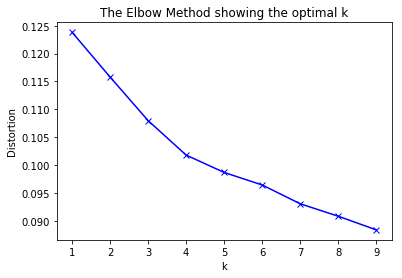

In [25]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Using k means clustering algorithm

In [26]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)
kmeans.labels_[0:10]

array([0, 0, 0, 1, 0, 0, 2, 0, 0, 0], dtype=int32)

In [27]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
brooklyn_merged = brooklyn_data
brooklyn_merged = brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
brooklyn_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn,Bay Ridge,40.625801,-74.030621,0,Italian Restaurant,Pizza Place,American Restaurant,Bar,Greek Restaurant,Hookah Bar,Sushi Restaurant,Seafood Restaurant,Sandwich Place,Thai Restaurant
1,Brooklyn,Bensonhurst,40.611009,-73.995180,1,Chinese Restaurant,Italian Restaurant,Pizza Place,Sushi Restaurant,Dumpling Restaurant,Bar,Shabu-Shabu Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Fried Chicken Joint
2,Brooklyn,Sunset Park,40.645103,-74.010316,0,Pizza Place,Latin American Restaurant,Mexican Restaurant,Sandwich Place,Italian Restaurant,BBQ Joint,Bar,Filipino Restaurant,French Restaurant,Fried Chicken Joint
3,Brooklyn,Greenpoint,40.730201,-73.954241,0,Bar,Pizza Place,Cocktail Bar,Mexican Restaurant,French Restaurant,New American Restaurant,Polish Restaurant,Italian Restaurant,Sandwich Place,Wine Bar
4,Brooklyn,Gravesend,40.595260,-73.973471,2,Pizza Place,Italian Restaurant,Bar,Chinese Restaurant,Wings Joint,Greek Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint


In [28]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [40]:
df=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Flatbush,Mexican Restaurant,Caribbean Restaurant,Italian Restaurant,Juice Bar,Sandwich Place,Pizza Place,Chinese Restaurant,Middle Eastern Restaurant,German Restaurant,Fast Food Restaurant
10,East Flatbush,Chinese Restaurant,Caribbean Restaurant,Wings Joint,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
25,Cypress Hills,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Latin American Restaurant,Salon / Barbershop,Pizza Place,South American Restaurant,Spanish Restaurant,Gay Bar,Ethiopian Restaurant
27,Starrett City,American Restaurant,Pizza Place,Caribbean Restaurant,Wings Joint,Halal Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
29,Flatlands,Fast Food Restaurant,Caribbean Restaurant,Sandwich Place,Fried Chicken Joint,Bar,Halal Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,Gay Bar
32,Coney Island,Caribbean Restaurant,Pizza Place,Wings Joint,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
42,Prospect Lefferts Gardens,Caribbean Restaurant,Pizza Place,Indian Restaurant,Sushi Restaurant,Spanish Restaurant,Juice Bar,Dive Bar,Italian Restaurant,Tapas Restaurant,Chinese Restaurant
47,Prospect Park South,Fast Food Restaurant,Caribbean Restaurant,Pizza Place,Latin American Restaurant,Mexican Restaurant,Sandwich Place,Bar,Fried Chicken Joint,Chinese Restaurant,Taco Place
54,Ditmas Park,Caribbean Restaurant,Chinese Restaurant,Pizza Place,Ramen Restaurant,Seafood Restaurant,Latin American Restaurant,Sandwich Place,Taco Place,Tapas Restaurant,Bar
55,Wingate,Fast Food Restaurant,Juice Bar,Vietnamese Restaurant,BBQ Joint,Chinese Restaurant,Fried Chicken Joint,Wings Joint,Halal Restaurant,Filipino Restaurant,French Restaurant


In [42]:
freq = df['1st Most Common Venue'].value_counts()
freq.head(4)

Caribbean Restaurant    5
Fast Food Restaurant    4
Fried Chicken Joint     1
Mexican Restaurant      1
Name: 1st Most Common Venue, dtype: int64

In [45]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

Text(0, 0.5, 'Count')

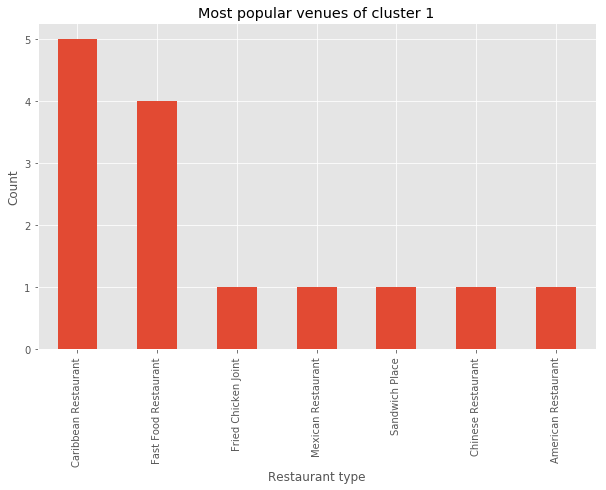

In [47]:
freq.plot(kind='bar', figsize=(10, 6))
plt.title('Most popular venues of cluster 1')
plt.xlabel('Restaurant type')
plt.ylabel('Count')

Cluster 2

In [53]:
df = brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bensonhurst,Chinese Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Hotpot Restaurant,Dumpling Restaurant,Shabu-Shabu Restaurant,Russian Restaurant,American Restaurant,Asian Restaurant
4,Gravesend,Pizza Place,Italian Restaurant,Eastern European Restaurant,Bar,Chinese Restaurant,Hookah Bar,German Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
7,Manhattan Terrace,Pizza Place,Japanese Restaurant,Steakhouse,German Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
9,Crown Heights,Pizza Place,Burger Joint,Salon / Barbershop,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
26,East New York,Asian Restaurant,Pizza Place,Spanish Restaurant,Wings Joint,Greek Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
31,Manhattan Beach,Sandwich Place,Pizza Place,Dumpling Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
34,Borough Park,Pizza Place,Fast Food Restaurant,Eastern European Restaurant,American Restaurant,Restaurant,Kosher Restaurant,Greek Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint
37,Marine Park,Pizza Place,Wings Joint,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant
46,Midwood,Pizza Place,Falafel Restaurant,Italian Restaurant,Wings Joint,Greek Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
58,New Lots,Pizza Place,Salon / Barbershop,Asian Restaurant,Chinese Restaurant,Spanish Restaurant,German Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant


Text(0, 0.5, 'Count')

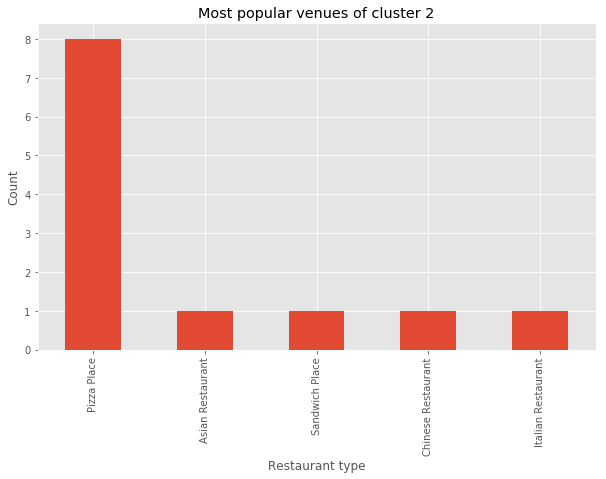

In [54]:
freq = df['1st Most Common Venue'].value_counts()
freq.plot(kind='bar', figsize=(10, 6))
plt.title('Most popular venues of cluster 2')
plt.xlabel('Restaurant type')
plt.ylabel('Count')

Cluster 3

In [57]:
df=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Canarsie,Asian Restaurant,Chinese Restaurant,Caribbean Restaurant,Wings Joint,Halal Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar
59,Paerdegat Basin,Asian Restaurant,Chinese Restaurant,Wings Joint,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar


Text(0, 0.5, 'Count')

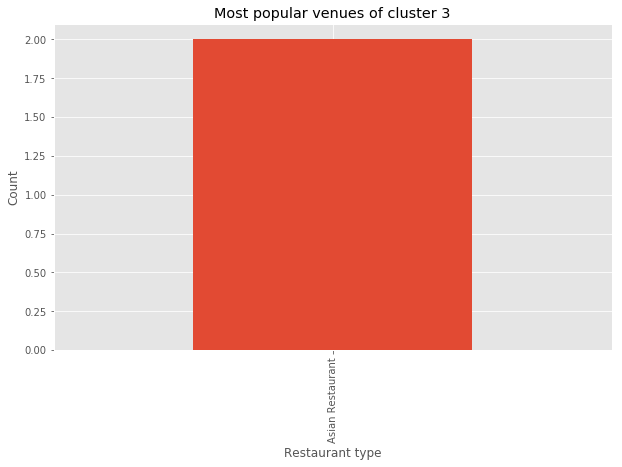

In [58]:
freq = df['1st Most Common Venue'].value_counts()
freq.plot(kind='bar', figsize=(10, 6))
plt.title('Most popular venues of cluster 3')
plt.xlabel('Restaurant type')
plt.ylabel('Count')

Cluster 4

In [59]:
df=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3, brooklyn_merged.columns[[1] + list(range(5, brooklyn_merged.shape[1]))]]
df

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bay Ridge,Italian Restaurant,Pizza Place,Greek Restaurant,American Restaurant,Bar,Hookah Bar,Sandwich Place,Seafood Restaurant,Chinese Restaurant,Middle Eastern Restaurant
2,Sunset Park,Latin American Restaurant,Pizza Place,Mexican Restaurant,Italian Restaurant,Sandwich Place,Hotel Bar,Hotpot Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
3,Greenpoint,Bar,Pizza Place,Cocktail Bar,Mexican Restaurant,Polish Restaurant,Salon / Barbershop,Sandwich Place,French Restaurant,Italian Restaurant,New American Restaurant
5,Brighton Beach,Eastern European Restaurant,Restaurant,Sushi Restaurant,Fast Food Restaurant,Russian Restaurant,Korean Restaurant,Mediterranean Restaurant,Taco Place,Fried Chicken Joint,Indian Restaurant
6,Sheepshead Bay,Turkish Restaurant,Sandwich Place,Karaoke Bar,Chinese Restaurant,Pizza Place,Restaurant,Russian Restaurant,Italian Restaurant,American Restaurant,Bar
11,Kensington,Sandwich Place,Thai Restaurant,Pizza Place,Japanese Restaurant,Restaurant,Mexican Restaurant,Wings Joint,Gay Bar,Falafel Restaurant,Fast Food Restaurant
12,Windsor Terrace,Sushi Restaurant,Bar,Chinese Restaurant,Middle Eastern Restaurant,Salad Place,American Restaurant,Italian Restaurant,Indian Restaurant,German Restaurant,Falafel Restaurant
13,Prospect Heights,Bar,Cocktail Bar,Thai Restaurant,Pizza Place,Mexican Restaurant,Southern / Soul Food Restaurant,New American Restaurant,Beer Bar,American Restaurant,North Indian Restaurant
14,Brownsville,Restaurant,Pizza Place,Fried Chicken Joint,Spanish Restaurant,Burger Joint,Wings Joint,German Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
15,Williamsburg,Bar,Steakhouse,Burger Joint,Latin American Restaurant,Taco Place,Korean Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Wine Bar,Pizza Place


Text(0, 0.5, 'Count')

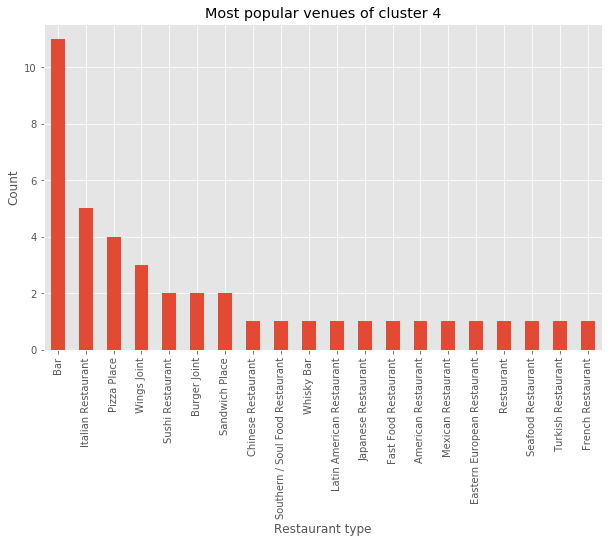

In [60]:
freq = df['1st Most Common Venue'].value_counts()
freq.plot(kind='bar', figsize=(10, 6))
plt.title('Most popular venues of cluster 4')
plt.xlabel('Restaurant type')
plt.ylabel('Count')